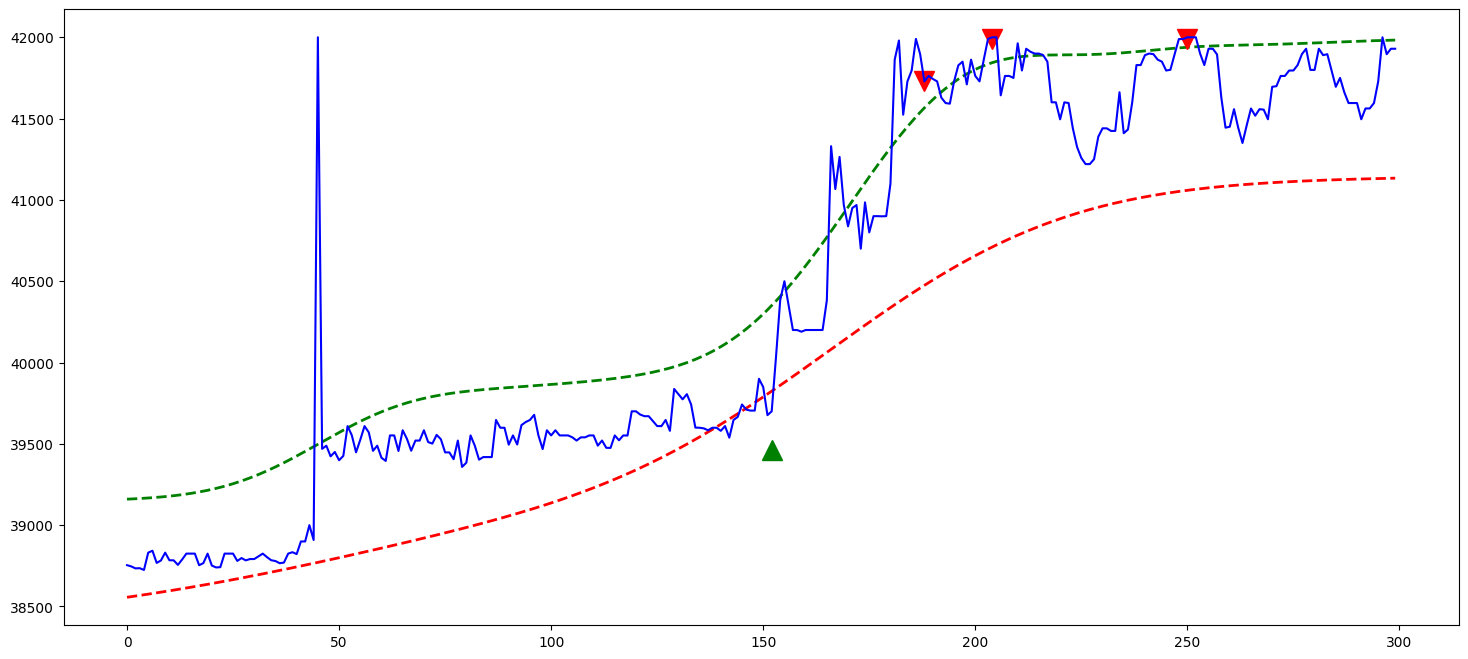

2


In [9]:
import pandas as pd
import numpy as np
from binance.um_futures import UMFutures
import matplotlib.pyplot as plt
import math


y = []
k = 2
class NadarayaWatson:
    def __init__(self, key, secret, symbol, limit=300, interval='15m'):
        self.client = UMFutures(key=key, secret=secret)
        self.client.base_url = "https://testnet.binancefuture.com"
        self.symbol = symbol
        self.limit = limit
        self.interval = interval

    def live_data(self):
        candles = self.client.klines(symbol=self.symbol, interval=self.interval, limit=self.limit)
        loop_f, loop_t = 0, len(candles)
        from datetime import datetime

        time = [
            datetime.fromtimestamp(int(candles[i][0] / 1000))  # mili secons 1000
            for i in range(loop_t)
        ]
        open_ = np.array([float(candles[i][1]) for i in range(loop_f, loop_t)])
        high_ = np.array([float(candles[i][2]) for i in range(loop_f, loop_t)])
        low_ = np.array([float(candles[i][3]) for i in range(loop_f, loop_t)])
        close_ = np.array(
            [float(candles[i][4]) for i in range(loop_f, loop_t)])
        val_ = np.array([float(candles[i][5]) for i in range(loop_f, loop_t)])

        candles = pd.DataFrame({
            "Open": open_,
            "High": high_,
            "Low": low_,
            "Close": close_,
            "volume": val_,
            "time": time
        })
        time = pd.to_datetime(time)
        df = candles.set_index(time)

        # Convert 'Open', 'High', 'Low', 'Close' to numeric
        for column in ['Open', 'High', 'Low', 'Close']:
            df[column] = pd.to_numeric(df[column])
     
        #df=df[df.Open!=df.Close]
        # Filter by volume
        df=df[df.volume!=0]
        df.reset_index(drop=True, inplace=True)

        return df

    def calculate_nadaraya_watson_open(self, data):
        h = 18  # BANDWIDTH
        mult = 2.61  # MULTIPLIER
        sum_e = 0
        src = data

        for i in range(len(data)):
            sum_open = 0
            sumw = 0
            for j in range(len(data)):
                w = math.exp(-(math.pow(i - j, 2) / (h * h * 2)))
                sum_open += src[j] * w
                sumw += w
            y2 = sum_open / sumw
            sum_e += abs(data[i] - y2)
            y.insert(i, y2)

        upper_band_signal, upper_band = self.calculate_band_signal(data, (sum_e) / len(data) * (mult), 'upper')

        result_df = pd.DataFrame({
            "Upper_Band_signal": upper_band_signal,
        })

        return result_df, upper_band

    def calculate_nadaraya_watson_close(self, data):
        h = 42  # BANDWIDTH
        mult = 1.5  # MULTIPLIER
        sum_e = 0
        src = data

        for i in range(len(data)):
            sum_close = 0
            sumw = 0
            for j in range(len(data)):
                w = math.exp(-(math.pow(i - j, 2) / (h * h * 2)))
                sum_close += src[j] * w
                sumw += w
            y2 = sum_close / sumw
            sum_e += abs(data[i] - y2)
            y.insert(i, y2)

        lower_band_signal, lower_band = self.calculate_band_signal(data, sum_e / len(data) * mult, 'lower')

        result_df = pd.DataFrame({
            "Lower_Band_Signal": lower_band_signal,
        })

        return result_df, lower_band

    def calculate_band_signal(self, data, mae, band_type):
        band_signal = []
        fband, state, state_signal, band_temp = [], [], [], 0

        for i in range(len(data)):
            y2 = y[i]
            y1 = y[i - 1]

            # _UPPER_ (Open)
            if band_type == 'upper':
                if y[i] > y[i - 1]:
                    state.append(y[i])
                    if band_temp == 0:
                        state_signal.append(data[i])
                    else:
                        state_signal.append(np.nan)
                    band_temp = 1
                else:
                    band_temp = 0
                    state.append(np.nan)
                    state_signal.append(np.nan)

                fband.append(y[i] + mae)
                if data[i] > fband[i]:
                    # Check if it's also a pivot high
                    if self.is_pivot(i, data, pivot_type='high'):
                        band_signal.append(data[i])
                    else:
                        band_signal.append(np.nan)
                else:
                    band_signal.append(np.nan)

            # _LOWER_ (Close)
            elif band_type == 'lower':
                if y[i] < y[i - 1]:
                    state.append(y[i])
                    if band_temp == 0:
                        state_signal.append(data[i])
                    else:
                        state_signal.append(np.nan)
                    band_temp = 1
                else:
                    band_temp = 0
                    state.append(np.nan)
                    state_signal.append(np.nan)

                fband.append(y[i] - mae)
                if data[i] < fband[i]:
                    # Check if it's also a pivot low
                    if self.is_pivot(i, data, pivot_type='low'):
                        band_signal.append(data[i])
                    else:
                        band_signal.append(np.nan)
                else:
                    band_signal.append(np.nan)

        return band_signal, fband

    def is_pivot(self, candle, df, window=15, pivot_type='high'):
        """
        Detect if a candle is a pivot high or low.

        Args:
        - candle (int): Candle index.
        - data (np.ndarray): Data array.
        - window (int, optional): Window before and after the candle to test if a pivot. Default is 15.
        - pivot_type (str, optional): Type of pivot ('high' or 'low'). Default is 'high'.

        Returns:
        - bool: True if pivot high or low, False otherwise.
        """
        if candle - window < 0 or candle + window >= len(df):
            return False

        pivot_high = True
        pivot_low = True
        for i in range(candle - window, candle + window + 1):
            if df[candle] > df[i]:
                pivot_low = False
            if df[candle] < df[i]:
                pivot_high = False

        if pivot_type == 'high':
            return pivot_high
        elif pivot_type == 'low':
            return pivot_low
        else:
            return False
        
    def get_signal_type(result_df_combined):
        signal_type = []
        current_signal = None

        for i in range(len(result_df_combined)):
            upper_signal = result_df_combined["Upper_Band_signal"].iloc[i]
            lower_signal = result_df_combined["Lower_Band_Signal"].iloc[i]

            if pd.notna(upper_signal):
                if current_signal != 2:
                    signal_type.append(2)
                    current_signal = 2
                else:
                    signal_type.append(2)
            elif pd.notna(lower_signal):
                if current_signal != 1:
                    signal_type.append(1)
                    current_signal = 1
                else:
                    signal_type.append(1)
            else:
                signal_type.append(0)


        # Filter out zeros
        signal_type = [signal for signal in signal_type if signal != 0]

        return signal_type
    
    def plot_nadaraya_watson(self, data, result_df, upper_band, lower_band):
        plt.figure(figsize=(18, 8))
        plt.plot(np.array(upper_band), color='green', linestyle='--', linewidth=2)
        plt.plot(np.array(lower_band), color='red', linestyle='--', linewidth=2)
        plt.plot(np.array(result_df["Upper_Band_signal"]), color='red', marker='v', linestyle='dashed',
                 linewidth=2, markersize=15)
        plt.plot(np.array(result_df["Lower_Band_Signal"]), color='green', marker='^', linestyle='dashed',
                 linewidth=2, markersize=15)
        plt.plot(np.array(data[:]), color='blue', label='Data')
        plt.show()

# Example usage:
key = ''
secret = ''
symbol = "BTCUSDT"

nadaraya_watson = NadarayaWatson(key=key, secret=secret, symbol=symbol)
data = nadaraya_watson.live_data()
result_df_open, upper_band_open = nadaraya_watson.calculate_nadaraya_watson_open(data['Open'].values)
result_df_close, lower_band_close = nadaraya_watson.calculate_nadaraya_watson_close(data['Close'].values)

# Combine the results for plotting
result_df_combined = pd.concat([result_df_open, result_df_close["Lower_Band_Signal"]], axis=1)
upper_band_combined = np.concatenate([upper_band_open, np.full_like(lower_band_close, np.nan)])
lower_band_combined = np.concatenate([lower_band_close, np.full_like(upper_band_open, np.nan)])

nadaraya_watson.plot_nadaraya_watson(data['High'], result_df_combined, upper_band_combined, lower_band_combined)



def final():
    # Example usage:
    signal_type = NadarayaWatson.get_signal_type(result_df_combined)
    if signal_type:
        return signal_type[-1]
    else:
        return 0

print(final())